According to the [proof](https://github.com/chengsoonong/eheye/tree/master/writing/QuantUCB_orderstat), the proposed policy for exponential distribution with tuning hyperparamters $\alpha, \beta$ is:

$$argmax_{i \in \mathcal{K}} \hat{m}_{i, T_i(t)} + \beta(\sqrt{2v_t \varepsilon} + 2 \varepsilon \sqrt{v_t/T_i(t)})$$

where $\hat{m}_{i, T_i(t)}$ is the empirical median for arm i at the round t, $\varepsilon = \alpha \log t$, $v_t = \frac{8 \sigma^2}{T_i(t) log2}$. $T_i(t)$ is the number of times arm i has been played until round t.

However we realized for the different choice of the exponential distribution parameter $\theta$, the difference of regret for estimated variance and true variance are quite different. More specific, for a small $\theta$ difference (large variance difference), the regret is relatively small, where the regret with the true variance is much smaller than the estimated one. For large $\theta$ difference (small variance difference), the regret is relatively big, where the regret with both the true variance and estimated variance are similar. 

It makes sense intuitively, when variance difference is big, the distributions are quite different and difference of medians are big, it is easy to distinguish better arms, so the regret is relatively small. But at the same time, the inaccurate variance estimation could make the selection inaccurate when compared with using the true variance. But when the variance difference is small, it hard to select better arms anyway, so the inaccurate variance estimation has a smaller influence. 

In the following, we design an experiment to verfication the above finding. We first fix the hyperparameter $\alpha, \beta = 2, 0.5$ and adjust the $\theta$. But note that the suitable hyperparamters may be different for different choice of the $\theta$, we need to adjust the hyperparamters later. 

We carefully choose four groups of variances are three arms:

| group | variance        | 
| ------| -------------   | 
| 1     | [0.5, 1, 1.5]   | 
| 2     | [0.4, 0.5, 0.6] | 
| 3     | [0.3, 0.5, 0.7] |  
| 4     | [1.4, 1.5, 1.6] |


the second and fourth group is set to compare whether the manitude of variance influence the performance when the difference of variance is the same. The first three groups are designed the show how the difference of variance influence the performance. The performance is evaluated in terms of expected cumulative regret (defiend by difference of medians) and the percentage of the best arm selected. 

We first show the corresponding scale $\gamma$ and paramter $\theta$ for the four groups of variances, where $\gamma = \sqrt{var}$, $\theta = \gamma^{-1}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UCB_discrete import Environment
from UCB_discrete import UCB_os_gau, UCB_os_exp, UCB1_os

%matplotlib inline

In [2]:
class Exp_Environment():
    """Environment for distribution reward of arms.
    
    Parameters
    ----------------------------------------------
    scale: gamma
    """
    def __init__(self, scale=1.0, size = None):  
        self.scale = scale
        self.size = size
        
    def sample(self):
        # f = 1/scale exp(-x/scale)
        return np.random.exponential(self.scale, self.size)

In [3]:
def cal_paras(var_lists):
    gamma_list = []
    theta_list = []
    for var in var_lists:
        gamma_list.append(np.sqrt(var))
        theta_list.append(1.0/np.sqrt(var))
    return gamma_list, theta_list

def env_setting(var_lists, num_arms): 
    gamma_list, theta_list = cal_paras(var_lists)
    
    rewards_env_list = []
    medians_list =[]
    means_list = []

    num_samples = 10000

    #f = plt.figure(figsize=(5,15))
    for j, gamma in enumerate(gamma_list):
        #plt.subplot(4,1,j+1)
        #plt.title(str(j) + ": " + str(gamma))
        print('gamma: ', gamma)
        rewards_env = []
        medians = []
        means = []

        for i in range(num_arms):
            rewards_env.append(Exp_Environment(scale = gamma[i]))
            samples = np.random.exponential(scale = gamma[i], size = num_samples)
            #plt.hist(samples, label = 'arm ' + str(i), alpha = 0.3)
            medians.append(np.median(samples))
            means.append(np.mean(samples))
        #plt.legend()
        print('medians: ', medians)
        print('means: ', means)
        rewards_env_list.append(rewards_env)
        medians_list.append(medians)
        means_list.append(means)
        
    return gamma_list, rewards_env_list, medians_list, means_list

In [4]:
def run_test(rewards_env_list, medians_list, means_list, num_exper, num_rounds, alpha, beta):

    regrets_est_var_exp_dict = {}
    regrets_true_var_exp_dict = {}
    regrets_ucb1_dict = {}

    f = plt.figure(figsize=(5,4 * len(rewards_env_list)))

    for j, rewards_env in enumerate(rewards_env_list):
        print('start the ' + str(j) + " group:")
        medians = medians_list[j] 
        means = means_list[j]
        regrets = []

        plt.subplot(len(rewards_env_list),1,j+1)

        print('est variance...')

        for i in range(num_exper):
            agent = UCB_os_exp(rewards_env, num_rounds, medians, est_var = True, alpha = alpha, beta = beta)
            regrets.append(agent.play())

        np.asarray(regrets).reshape((num_exper, num_rounds-3))
        regrets_est = np.mean(regrets, axis = 0)
        regrets_est_var_exp_dict[j] = regrets_est

        regrets = []

        print('true variance...')

        for i in range(num_exper):
            agent = UCB_os_exp(rewards_env, num_rounds, medians, est_var = False, alpha = alpha, beta = beta)
            regrets.append(agent.play())

        np.asarray(regrets).reshape((num_exper, num_rounds-3))
        regrets_true = np.mean(regrets, axis = 0)
        regrets_true_var_exp_dict[j] = regrets_true
        
        print('ucb1...')
        alpha = 1.5
        regrets = []

        for i in range(num_exper):
            agent = UCB1_os(rewards_env, num_rounds, medians, alpha)
            regrets.append(agent.play())

        np.asarray(regrets).reshape((num_exper, num_rounds-3))
        regrets_ucb1 = np.mean(regrets, axis = 0)
        regrets_ucb1_dict[j] = regrets_ucb1
        
        plt.plot(regrets_est, label = 'regret (est var)')
        plt.plot(regrets_true, label = 'regret (true var)')
        plt.plot(regrets_ucb1, label = 'regret (ucb1)')
        plt.xlabel('iterations')
        plt.ylabel('expected cumulative regret')
        plt.title(str(j) + 'Exp')
        plt.legend()

    plt.show()
    return regrets_est_var_exp_dict, regrets_true_var_exp_dict, regrets_ucb1_dict

In [5]:
# setting 

num_rounds = 10000
num_exper = 10
num_arms = 3

alpha = 2
beta = 0.5

In [6]:
var_lists = [[0.5, 1, 1.5],[0.4, 0.5, 0.6],[0.3, 0.5, 0.7],[1.4, 1.5, 1.6]]
#var_lists = [[0.3, 0.5, 0.7]]

gamma_list, rewards_env_list, medians_list, means_list = env_setting(var_lists, num_arms)

gamma:  [0.70710678 1.         1.22474487]
medians:  [0.4833235234747284, 0.6956170175938399, 0.8459425972161755]
means:  [0.7046056718126193, 1.0034162979323609, 1.2289853576861296]
gamma:  [0.63245553 0.70710678 0.77459667]
medians:  [0.43514964388156596, 0.48808050829105354, 0.5370390506424609]
means:  [0.6398921047727721, 0.6962126618383573, 0.7698972658628558]
gamma:  [0.54772256 0.70710678 0.83666003]
medians:  [0.372176139523965, 0.5054301995315047, 0.5630667410742742]
means:  [0.5422345772526852, 0.7088279470093903, 0.8345391721884291]
gamma:  [1.18321596 1.22474487 1.26491106]
medians:  [0.8325006023746387, 0.8644735215609898, 0.8744951456847354]
means:  [1.1967052666163454, 1.2270204672699023, 1.2696735297518422]


start the 0 group:
est variance...
true variance...
ucb1...
start the 1 group:
est variance...
true variance...
ucb1...
start the 2 group:
est variance...
true variance...
ucb1...
start the 3 group:
est variance...
true variance...
ucb1...


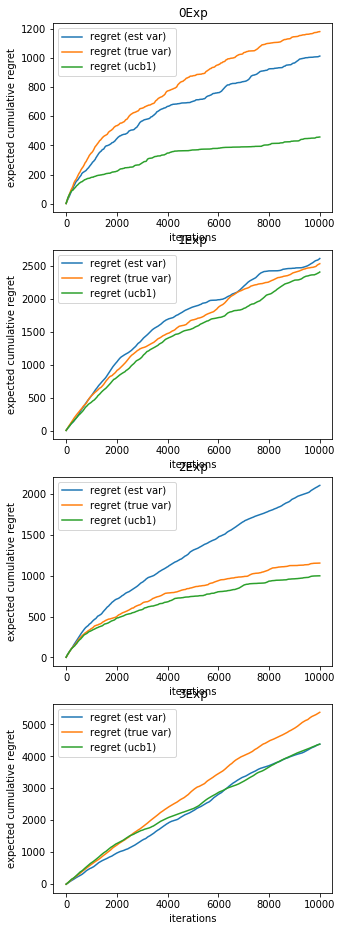

In [7]:
# evaluate by difference of mean
dict1, dict2, dict3 = run_test(rewards_env_list, medians_list, means_list, num_exper, num_rounds, alpha, beta)

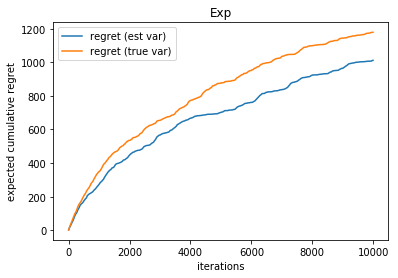

In [8]:
plt.plot(dict1[0], label = 'regret (est var)')
plt.plot(dict2[0], label = 'regret (true var)')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Exp')
plt.legend()

From the above results, we see for all the four groups, the performance of estimated variance and true variance are the similar, where group 3 has slightly smaller regret. The reason behind it might be both the variance and variance difference are small compared other groups. So the design another two experiment below, where the first group have a large variance, the second group has a large variance gap. 

In [9]:
var_lists = [[0.25, 1, 2.25],[0.1, 0.5, 0.8]]

gamma_list, rewards_env_list, medians_list = env_setting(var_lists, num_arms)

gamma:  [0.5 1.  1.5]
medians:  [0.35400762850386214, 0.7102952445199379, 1.055836576238187]
means:  [0.49894669878265696, 0.9963419452723625, 1.534860262982466]
gamma:  [0.31622777 0.70710678 0.89442719]
medians:  [0.21818351702768796, 0.48811996943064484, 0.6135582907236158]
means:  [0.31644390081759854, 0.6996793083860222, 0.9005429191096626]


ValueError: too many values to unpack (expected 3)

In [ ]:
run_test(rewards_env_list, medians_list, num_exper, num_rounds, alpha, beta)

In [ ]:
num_rounds = 10000
num_exper = 10

var_lists = [[0.36, 1, 4]]

gamma_list, rewards_env_list, medians_list = env_setting(var_lists, num_arms)

regrets_est_var_exp_dict, regrets_true_var_exp_dict = run_test(rewards_env_list, medians_list, num_exper, num_rounds, alpha, beta)